# Packages and Global Behavior

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from math import comb
from matplotlib import cm, colors, rc
from scipy.spatial.distance import mahalanobis as mh
from sklearn.covariance import MinCovDet
from sklearn.covariance import LedoitWolf
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
rc('text', usetex=True)

folder_fig = "figs"
dir_fig = lambda x: os.path.join(folder_fig, x)
np.random.seed(43)

def set_size(w, h, ax):
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# Aesthetic
end = '\033[0m'
bold = '\033[1m'
blue = '\033[94m'
red = '\033[91m'
header = "===================================="
n_spaces = 3

def print_results(dictionary):
    max_length = max(map(lambda x: len(x), dictionary))
    print(header)
    for key in dictionary:
        spaces_aux = n_spaces + (max_length - len(key))
        spaces = " " * spaces_aux
        print(bold + str(key) + end + spaces + str(dictionary[key]))

# Reading Data

In [24]:
# Read assets data
file = open("vida.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        try:
            row.append(float(acum))
        except ValueError:
            break
    data.append(row)

data = np.array(data, dtype=np.float)

# ECDF

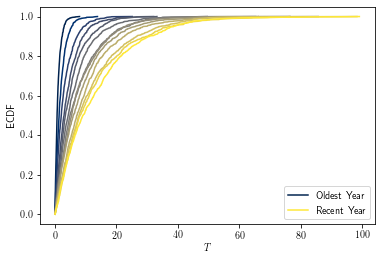

In [30]:
# Color Scheme Selected
color1 = plt.get_cmap('cividis')
color_norm = colors.Normalize(vmin=0, vmax=data.shape[1] - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)

# Legend and Plotting of Each Year
legends = {0: 'Oldest Year', data.shape[1] - 1: 'Recent Year'}
ecdfs = []
for i in range(data.shape[1]):
    color = scalar_map.to_rgba(i)
    ecdf = ECDF(data[:, i])
    ecdfs.append(ecdf)
    if i in legends.keys():
        plt.plot(ecdf.x, ecdf.y, color=color, label=legends[i])
    else:
        plt.plot(ecdf.x, ecdf.y, color=color)

# Plotting
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs.pdf"), bbox_inches='tight')
plt.show()

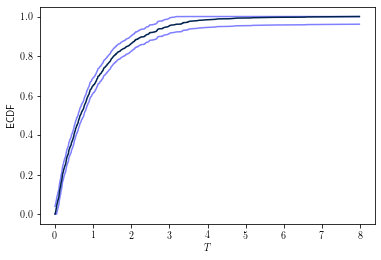

In [36]:
### Level of significance
alpha = 0.1

# Construction of bands
epsilon = np.sqrt(1 / (2 * data.shape[0]) * np.log(2 / alpha))

def bands(ecdf):
    lower = np.zeros(len(ecdf.y))
    upper = np.zeros(len(ecdf.y))
    for i in range(len(ecdf.y)):
        lower[i] = max(ecdf.y[i] - epsilon, 0)
        upper[i] = min(ecdf.y[i] + epsilon, 1)
    return lower, upper

# Bands for first year
lower, upper = bands(ecdfs[0])

# Plotting
plt.plot(ecdfs[0].x, lower, 'b', alpha=0.5)
plt.plot(ecdfs[0].x, upper, 'b', alpha=0.5)
plt.plot(ecdfs[0].x, ecdfs[0].y, color=scalar_map.to_rgba(0))
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdf_bands.pdf"), bbox_inches='tight')
plt.show()

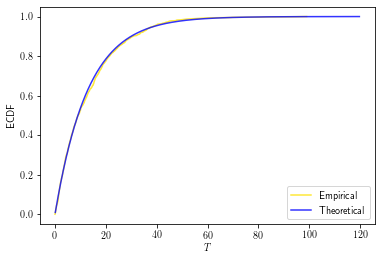

In [45]:
# Comparison to exponential distribution
params = [0, 13]
x_expon = np.linspace(st.expon.ppf(0.01, *params), st.expon.ppf(0.9999, *params), 1000)
y_expon = st.expon.cdf(x_expon, *params)

# Plotting
index = data.shape[1] - 1
plt.plot(ecdfs[-1].x, ecdfs[-1].y, color=scalar_map.to_rgba(index), label="Empirical")
plt.plot(x_expon, y_expon, color="b", alpha=0.8, label="Theoretical")
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdf-vs-theo.pdf"), bbox_inches='tight')
plt.show()

## Kernel Estimation

In [47]:
# method =
## 0 -> Uniform
## 1 -> Triangular
## 2 -> Epanechnikov
## 3 -> Bi-squared
## 4 -> Gaussian
def kernel_density(x, data, h, method=0):
    m = data.size
    u = (x - data) / h
    
    if h <= 0:
        h = data.std(ddof=1) * (4 / (3*m))**(1 / 5)
    ind = np.logical_and(-1 < u, u < 1).astype(np.int)
    if method == 0:
        I = 0.5 * ind
    elif method == 1:
        I = (1 - np.abs(u)) * ind
    elif method == 2:
        I = 0.75 * (1 - u ** 2) * ind
    elif method == 3:
        I = (15 / 16) * (1 - 2 * u ** 2 + u ** 4) * ind
    else:
        I = ((1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u ** 2))
    
    return 1 / (m * h) * I.sum()

# Estimate the probability density function for a given sample
def estimate_density(sample, h, method=0, xs=None):
    if xs is None:
        xs = np.sort(sample)
    density = np.zeros(xs.size)
    i = 0
    for x in xs:
        density[i] = kernel_density(x, sample, h, method=method)
        i += 1
    return xs, density

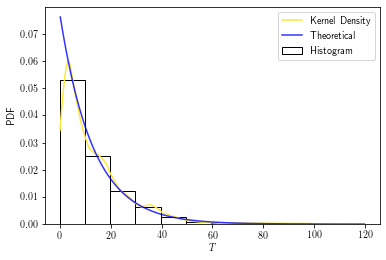

In [56]:
# Kernel Estimation
kernel_x, kernel_y = estimate_density(data[:, -1], 4, method=2)

# Exponential pdf
expon_pdf = st.expon.pdf(x_expon, *params)

# Plotting
index = data.shape[1] - 1
plt.hist(data[:, -1], color='w', ec='k', label="Histogram", density=True)
plt.plot(kernel_x, kernel_y, color=scalar_map.to_rgba(index), label="Kernel Density")
plt.plot(x_expon, expon_pdf, color="b", alpha=0.8, label="Theoretical")
plt.legend()
plt.xlabel("$T$")
plt.ylabel("PDF")
plt.savefig(dir_fig("pdf-vs-theo.pdf"), bbox_inches='tight')
plt.show()

# Glivenko Cantelli Theorem

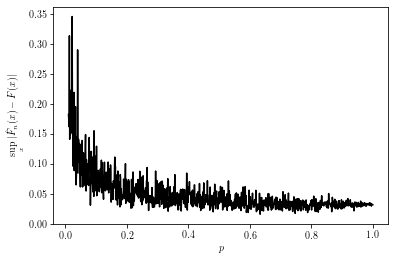

In [71]:
# Percentage of original data usage
nums = np.linspace(0.01, 1, 1000)
nums = np.append(nums, [1])

# Generate samples with each percentage
samples = []
for num in nums:
    samples.append(np.random.choice(data[:, -1], size=int(num * data[:, -1].size), replace=False))
    

# Calculate each difference
differences = []
for sample in samples:
    ecdf = ECDF(sample)
    real_expon = st.expon.cdf(ecdf.x, *params)
    
    difference = np.absolute(real_expon - ecdf.y)
    differences.append(difference.max())

# Plotting
plt.plot(nums, differences, 'k')
plt.xlabel("$p$")
plt.ylabel("$$\sup_x  \,|\hat{F}_n(x) - F(x)|$$")
plt.savefig(dir_fig("glivenko-cantelli.pdf"), bbox_inches='tight')
plt.show()

# Bootstrap

In [72]:
# Normal Bootstrap method
def normal_interval(stats, alpha, og):
    aux = (stats - np.mean(stats)) ** 2
    v_boot = 1 / len(stats) * aux.sum()
    z_alpha = st.norm.ppf(1 - alpha / 2)
    interval = (og - z_alpha*np.sqrt(v_boot), og + z_alpha*np.sqrt(v_boot))
        
    return interval, v_boot


# Percentile interval methods
def percentile_interval(stats, alpha, og):
    theta_alpha_inf = np.quantile(stats, (1 - alpha / 2))
    theta_alpha_sup = np.quantile(stats, alpha / 2)
    interval = (2*og - theta_alpha_inf, 2*og - theta_alpha_sup)
    
    return interval

    
# Studentized pivotal interval method
def studentized_pivotal_interval(stats, statistic, n, samples, se_boot, multi, alpha, og):
    if se_boot is None:
        aux = (stats - np.mean(stats)) ** 2
        se_boot = np.sqrt(1 / len(stats) * aux.sum())
    se_bs = []
    for sample in samples:
        _, add = bootstrap(sample, n, statistic, alpha=alpha, multi=multi)
        se_bs.append(np.sqrt(add['vboot']))
    z_star = []
    for i in range(len(se_bs)):
        z_star.append((stats[i] - og) / se_bs[i] )
        
    z_alpha_1 = np.quantile(z_star, 1 - alpha / 2)
    z_alpha = np.quantile(z_star, alpha / 2)
        
    interval = (og - z_alpha_1 * se_boot, og - z_alpha * se_boot)
    
    return interval

def pivotal_intervals(stats, alpha, og):
    theta_alpha = np.quantile(stats, 1 - alpha / 2)
    theta_alpha1 = np.quantile(stats, alpha / 2)
    
    interval = (2*og - theta_alpha, 2*og - theta_alpha1)
    
    return interval

def parametric_bootstrap(series, n, dist, statistic, params, alpha=0.05):
    stats = []
    for i in range(n):
        sample = dist.rvs(*params, size=series.size)
        stats.append(statistic(sample))
    stats = np.array(stats)
    v_boot = stats.var(ddof=0)
    og = statistic(series)
    z_alpha = st.norm.ppf(1 - alpha / 2)
    interval = (og - z_alpha*np.sqrt(v_boot), og + z_alpha*np.sqrt(v_boot))

    return interval, stats
    

# Bootstrap method
## 0 -> Normal interval
## 1 -> Percentile interval
## 2 -> Studentized pivotal interval
## 3 -> Pivotal intervals
def bootstrap(series, n, statistic, alpha=0.05, method=0, multi=False, se_boot=None):
    # Calculate the statistic
    samples = []
    if multi:
        indexes = np.array(range(series.shape[1]))
        for i in range(n):
            indexes0 = np.random.choice(indexes, size=series.shape[1])
            samples.append(np.array(list(map(lambda x: series[:, x], indexes0))))
    else:
        for i in range(n):
            samples.append(np.random.choice(series, size=len(series)))
    
    stats = np.array(list(map(lambda x: statistic(x), samples)))
    og = statistic(series)
    add = {}
    add['stats'] = stats

    # Calculate bootstrap respect the chosen method
    if method == 0:
        interval, v_boot = normal_interval(stats, alpha, og)
        add['vboot'] = v_boot
    elif method == 1:
        interval = percentile_interval(stats, alpha, og)
    elif method == 2:
        interval = studentized_pivotal_interval(stats, statistic, n, samples, se_boot, multi, alpha, og)
    elif method == 3:
        interval = pivotal_intervals(stats, alpha, og)
        
    return interval, add

In [82]:
statistic = lambda x: x.max()
intervals = []
for j in range(4):
    interval, _ = bootstrap(data[:, 0], 1000, statistic, method=j)
    intervals.append(interval)

results = {"Original Value": statistic(data[:, 0]),
           "Normal method": intervals[0],
           "Percentile Interval": intervals[1],
           "Studentized Pivotal Interval": intervals[2],
           "Pivotal Intervals": intervals[3]}

print_results(results)

Original Value                 7.9823
Normal method                  (6.913194486060116, 9.051405513939885)
Percentile Interval            (7.9823, 9.4068)
Studentized Pivotal Interval   (7.9823, 13.951079015313645)
Pivotal Intervals              (7.9823, 9.4068)


# Jackknife

In [83]:
# JackKnife method
def jackknife_bias(series, stastistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    t_m = np.mean(stats)
    b_jack = (len(series) - 1) * (t_m - og)
    return b_jack

def jackknife_var(series, statistic, multi=False):
    # Calculate statistics
    og = statistic(series)
    stats = []
    if multi:
        size = series.shape[1]
        for i in range(series.shape[1]):
            rows = []
            for j in range(series.shape[0]):
                rows.append(np.concatenate((series[j, :i], series[j, (i+1):])))
            t_i = np.array(rows)
            stats.append(statistic(t_i))
    else:
        size = len(series)
        for i in range(len(series)):
            t_i = np.concatenate((series[:i], series[(i+1):]))
            stats.append(statistic(t_i))
    ti_v = size * og - (size - 1) * stats
    
    # Calculate variance
    s2 = ti_v.var(ddof=1)
    return s2 / size

In [84]:
b_jack = jackknife_bias(data[:, 0], statistic)
v_jack = jackknife_var(data[:, 0], statistic)

results = {"Bias Jackknife": b_jack,
           "Variance Jackknife": v_jack}
print_results(results)

Bias Jackknife       -0.6563410230704676
Variance Jackknife   4.338154749167341e-07


# Nadaraya-Watson Regression

In [85]:
# Read assets data
file_costs = open("costos.txt").readlines()
costs = []
for line in file_costs:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        try:
            row.append(float(acum))
        except ValueError:
            break
    costs.append(row)

costs = np.array(costs, dtype=np.float)

In [172]:
# method =
#   0 -> Uniform
#   1 -> Triangular
#   2 -> Epanechnikov
#   3 -> Bi-squared
#   4 -> Gaussian
def kernel_nw_regression(xs, ys, h, method=0):
   
    if h <= 0:
        h = xs.std(ddof=1) * (4 / (3*xs.size))**(1 / 5)
        
    est = np.zeros(xs.size)
    for j in range(xs.size):
        u = (xs[j] - xs) / h
        
        ind = np.logical_and(-1 < u, u < 1).astype(np.int)
        if method == 0:
            I = 0.5 * ind
        elif method == 1:
            I = (1 - np.abs(u)) * ind
        elif method == 2:
            I = 0.75 * (1 - u ** 2) * ind
        elif method == 3:
            I = (15 / 16) * (1 - 2 * u ** 2 + u ** 4) * ind
        else:
            I = ((1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u ** 2))

        denom = I.sum()
        num = I.dot(ys)
        est[j] = num / denom

    return est

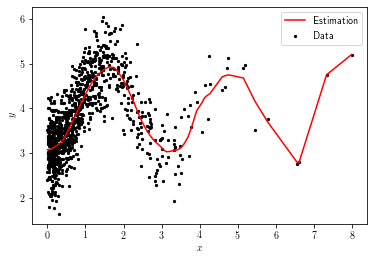

In [196]:
# Create Data
y = costs
x = data[:, 0]

aux_xy = np.array([x, y[:, 0]]).transpose().tolist()
aux_xy = sorted(aux_xy, key=lambda t: t[0])
aux_xy = np.array(aux_xy)

x = aux_xy[:, 0]
y = aux_xy[:, 1]

# Nadaraya-Watson Estimation
estimation = kernel_nw_regression(x, y, 0.4, method=2)

# Plotting
plt.scatter(x, y, color='k', label='Data', s=5)
plt.plot(x, estimation, 'r', label="Estimation")
plt.xlabel("$x$") 
plt.ylabel("$y$")
plt.legend()
plt.savefig(dir_fig("scatter-vs-model.pdf"), bbox_inches='tight')
plt.show()

# Homogeneity Test

## Univariate

In [89]:
# Wilcoxon ranksum test
results = np.ones((data.shape[1], data.shape[1]))
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        if i == j:
            continue
        _, results[i, j] = st.ranksums(data[:, i], data[:, j])

# Result of test
alpha = 0.05
print((results <= alpha).astype(np.int))

[[0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 0]]


## Multivariate

In [91]:
# Tukey statistical depth
def depth_tukey(point, data, n):
    r, c = data.shape
    
    u = np.random.normal(size=(c, n))
    
    # Calculate scalars
    scalar = data.dot(u)
    
    scalar2 = point.dot(u)
    
    replic = np.ones((r, 1)).dot(scalar2)
    diff = scalar - replic
    diff_indicator = (diff > 0).astype(np.int)
    
    return diff_indicator.mean(axis=0).min()


# Mahalanobis distance
def mahal(u, v, inv_matrix):
    distance = []
    
    for i in range(u.shape[0]):
        distance.append(mh(u[i, :], v, inv_matrix) ** 2)
    distance = np.array(distance)

    return distance


# Mahalanobis statistical depth
def depth_mahal(point, data):
    mean = data.mean(axis=0)
    if point.ndim == 1:
        point = point.reshape((1, data.shape[1]))
    
    inv_cov = np.linalg.inv(np.cov(data.transpose()))
    
    depth = 1 / (1 + mahal(point, mean, inv_cov))
    
    return depth

In [92]:
# D-D Plot
def ddplot(sample0, sample1, filename=None, method=0):
    others = []
    
    sample = np.array(sample0.tolist() + sample1.tolist())
    z_0 = np.zeros(sample.shape[0])
    z_1 = np.zeros(sample.shape[0])
    
    for i in range(sample.shape[0]):
        point = sample[i, :].reshape((1, sample.shape[1]))
        if method == 0:
            z_0[i] = depth_tukey(point, sample0, 300)
            z_1[i] = depth_tukey(point, sample1, 300)
        else:
            z_0[i] = depth_mahal(point, sample0)
            z_1[i] = depth_mahal(point, sample1)
    
        
    plt.scatter(z_0, z_1, s=5, color='k')
    
    if filename is not None:
        plt.savefig(dir_fig(filename), bbox_inches='tight')
    plt.show()
    
    return z_0, z_1

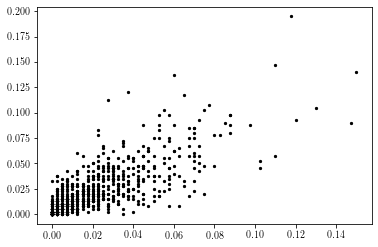

In [94]:
data1 = data[:400, :]
data2 = data[-400:, :]
z_0, z_1 = ddplot(data1, data2, filename="ddplot-400.pdf")

In [184]:
# Plot the regression model, given the estimated parameters.
def plot_regression_model(x, y, title, beta0, beta1):
    xs = np.linspace(x.min(), x.max(), 1000)
    ys = (beta0 + beta1 * xs).reshape(xs.size)
    plt.plot(xs, ys, "r")
    plt.scatter(x, y, color="k", s=5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.savefig(dir_fig(title), bbox_inches='tight')
    plt.show()
    

# Construct the regression model and plot the data with it's linear model.
def regression_model(x, y, title):
    # Fitting model
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.summary())

    # Finding parameters
    beta1 = results.params
    beta0 = y.mean() - beta1 * x.mean()

    # Plotting
    plot_regression_model(x, y, title, beta0, beta1)
    
    return results

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.770
Method:                 Least Squares   F-statistic:                              2672.
Date:                Sat, 23 May 2020   Prob (F-statistic):                   4.40e-257
Time:                        18:57:18   Log-Likelihood:                          2181.1
No. Observations:                 800   AIC:                                     -4360.
Df Residuals:                     799   BIC:                                     -4356.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

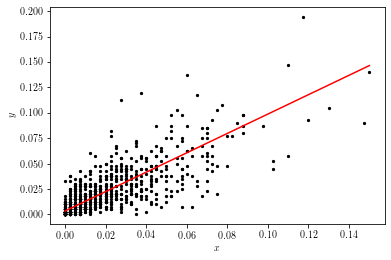

beta0   [0.00314625]
beta1   [0.95645174]


In [97]:
results_400 = regression_model(z_0, z_1, "scatter-vs-model-ddplot-400.pdf")

beta1_400 = results_400.params
beta0_400 = z_1.mean() - beta1_400 * z_0.mean()

r0 = {"beta0": beta0_400, "beta1": beta1_400}
print_results(r0)

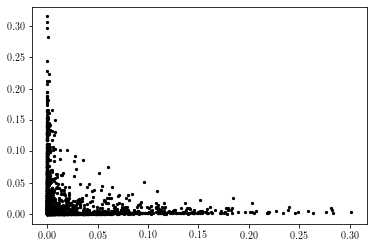

In [99]:
data1_5 = data[:, :5]
data2_5 = data[:, -5:]
z_05, z_15 = ddplot(data1_5, data2_5, filename="ddplot-5.pdf")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              8.811
Date:                Sat, 23 May 2020   Prob (F-statistic):                     0.00303
Time:                        19:02:31   Log-Likelihood:                          3294.4
No. Observations:                1994   AIC:                                     -6587.
Df Residuals:                    1993   BIC:                                     -6581.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

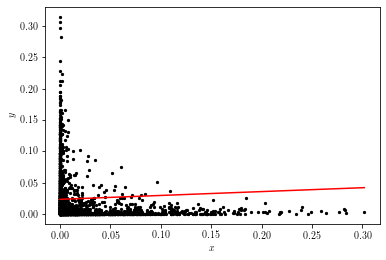

beta0   [0.02124251]
beta1   [0.06156629]


In [100]:
results_5 = regression_model(z_05, z_15, "scatter-vs-model-ddplot-5.pdf")

beta1_5 = results_5.params
beta0_5 = z_1.mean() - beta1_5 * z_0.mean()

r0 = {"beta0": beta0_5, "beta1": beta1_5}
print_results(r0)

# Linear Regression

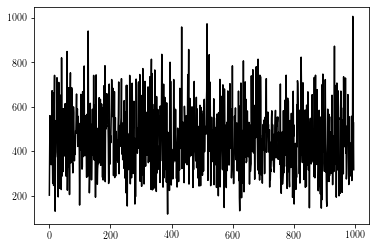

In [118]:
betas = np.linspace(13, 1, 13).reshape((1, 13))

# Construction of y
epsilon = np.random.normal(loc=0, scale=50, size=(data.shape[0], 1))
yc = data.dot(betas.transpose()) + epsilon

plt.plot(yc, 'k')
plt.show()

In [226]:
# Generic method to convert from correlation matrix to covariance matrix
def corr_to_cov(data, correlation):
    stds = data.std(axis=0, ddof=1)

    cov = np.zeros(correlation.shape)
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            cov[i, j] = correlation[i, j] * stds[i] * stds[j]

    return cov

# Calculate comedian for two vectors
def comedian(u, v):
    median_u = np.quantile(u, 0.5)
    median_v = np.quantile(v, 0.5)
    
    aux = (u - median_u) * (v - median_v)
    
    return np.quantile(aux, 0.5)

# Calculate comedian matrix
def calculate_com(sample):
    com = np.zeros((sample.shape[1], sample.shape[1]))
    for i in range(sample.shape[1]):
        for j in range(sample.shape[1]):
            com[i, j] = comedian(sample[:, i], sample[:, j])
    
    return com

# method =
#    0 -> Spearman
#    1 -> Kendall
def calculate_cov_corr(sample, method=0):
    if method == 0:
        # Calculate Spearman
        spearman = pd.DataFrame(sample).corr(method="spearman").to_numpy()
        cov = corr_to_cov(sample, spearman)
    else:
        # Calculate Kendall
        kendall = pd.DataFrame(sample).corr(method="kendall").to_numpy()
        cov = corr_to_cov(sample, kendall)
    return cov


# Calculate covariance of MCD
def calculate_cov_MCD(sample):
    return MinCovDet().fit(sample).covariance_

# Calculate covariance of shrinkages
def calculate_cov_shrinkages(sample):
    return LedoitWolf().fit(sample).covariance_

# Calculate linear regression with different covariance matrix
#    method =
#       0 -> Comedian matrix
#       1 -> Spearman
#       2 -> Kendall
#       3 -> FastMCD
#       4 -> Shrinkages
def cov_linear_regression(x, y, method=0):
    if x.ndim == 1:
        x_aux = x.reshape((x.size, 1))
    else:
        x_aux = x
    
    method_1 = method - 1
    if method == 0:
        calculation = lambda matrix: calculate_com(matrix)
    elif method in range(1, 3):
        calculation = lambda matrix: calculate_cov_corr(matrix, method=method_1)
    elif method == 3:
        calculation = lambda matrix: calculate_cov_MCD(matrix)
    else:
        calculation = lambda matrix: calculate_cov_shrinkages(matrix)
    
    
    cov_x = calculation(x_aux)
    covs = []
    for i in range(x_aux.shape[1]):
        sample = np.array([x_aux[:,i], y[:, 0]]).transpose()
        
        cov_xy = calculation(sample)[1, 0]
        
        covs.append([cov_xy])
    covs = np.array(covs).reshape((len(covs), 1))
    
    beta1 = np.linalg.inv(cov_x).dot(covs)
    return beta1

def distance(beta1, x, y, betas):
    means = x.mean(axis = 0).reshape((1, x.shape[1]))
    beta0 = y.mean() - means.dot(beta1)

    # Distance to original vector
    db1 = np.linalg.norm(beta1.transpose() - betas)
    
    # Distance of outputs
    y_est = x.dot(beta1) + beta0
    dy = np.abs(y - y_est).max()
    results = {"Distance to beta1": db1,
               "Estimation to beta0": beta0,
               "Distance to output": dy}
    print_results(results)

In [227]:
# Fitting model
model = sm.OLS(yc, data)
results = model.fit()

# Finding parameters
beta1_ls = results.params.reshape((13, 1))
distance(beta1_ls, data, yc, betas)

Distance to beta1     1.4383433471610485
Estimation to beta0   [[-0.434626]]
Distance to output    185.37938487242027


In [228]:
# Comedian
beta1_cm = cov_linear_regression(data, yc, method=0)
distance(beta1_cm, data, yc, betas)

Distance to beta1     4.593937141372729
Estimation to beta0   [[51.71019149]]
Distance to output    215.958000146906


In [217]:
# Spearman
beta1_sp = cov_linear_regression(data, yc, method=1)

distance(beta1_sp, data, yc, betas)

Distance to beta1     3.61123409353763
Estimation to beta0   [[51.35638786]]
Distance to output    196.0886227261881


In [218]:
# Kendall
beta1_k = cov_linear_regression(data, yc, method=2)

distance(beta1_k, data, yc, betas)

Distance to beta1     11.142412333985343
Estimation to beta0   [[185.74515517]]
Distance to output    236.36306295987572


In [219]:
# Fast MCD
beta1_mcd = cov_linear_regression(data, yc, method=3)

distance(beta1_mcd, data, yc, betas)

Distance to beta1     21.121886020124183
Estimation to beta0   [[332.41282208]]
Distance to output    374.5109604369636


In [220]:
# Shrinkages
beta1_sh = cov_linear_regression(data, yc, method=4)

distance(beta1_sh, data, yc, betas)

Distance to beta1     9.788842777737935
Estimation to beta0   [[21.95593889]]
Distance to output    175.61039660596177
